In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.optimize import minimize

In [2]:
# Load datasets
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

# Data Prep

In [3]:
order_products = pd.concat([order_products_prior, order_products_train])

# Merge with other tables to get full product info
merged_data = pd.merge(order_products, orders, on='order_id')
merged_data = pd.merge(merged_data, products, on='product_id')
merged_data = pd.merge(merged_data, aisles, on='aisle_id')
merged_data = pd.merge(merged_data, departments, on='department_id')

In [19]:
customer_data = merged_data.groupby('user_id').agg({
    'reordered': 'sum',  # Total number of reorders
    'order_id': 'nunique',  # Total number of orders
    'add_to_cart_order': 'mean',  # Average position in cart
    'order_dow': 'mean',  # Average day of the week orders are placed
    'order_hour_of_day': 'mean',  # Average hour of the day orders are placed
    'days_since_prior_order': 'mean'  # Average days between orders
}).reset_index()

In [20]:
latest_order = merged_data.groupby('user_id')['days_since_prior_order'].max().reset_index()
latest_order['churn'] = latest_order['days_since_prior_order'] > 7
customer_data = pd.merge(customer_data, latest_order[['user_id', 'churn']], on='user_id')

In [21]:
customer_data.head()

,user_id,reordered,order_id,add_to_cart_order,order_dow,order_hour_of_day,days_since_prior_order,churn
0,1,51,11,4.000000,2.857143,10.142857,19.200000,True
1,2,105,15,9.575221,1.867257,10.517699,18.009390,True
2,3,55,12,4.443182,1.011364,16.352273,11.487179,True
3,4,1,5,2.777778,4.722222,13.111111,15.357143,True
4,5,18,5,5.413043,1.304348,14.804348,12.314286,True


# Customer Segmentation

In [22]:
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['segment'] = kmeans.fit_predict(customer_data.drop(['user_id', 'churn'], axis=1))

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Training model for each segment to predict churn

In [23]:
# Train models for each segment
segment_models = {}
scalers = {}

for segment in customer_data['segment'].unique():
    segment_data = customer_data[customer_data['segment'] == segment]
    X_seg = segment_data.drop(['user_id', 'churn', 'segment'], axis=1)
    y_seg = segment_data['churn']
    
    X_train_seg, X_test_seg, y_train_seg, y_test_seg = train_test_split(X_seg, y_seg, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_seg_scaled = scaler.fit_transform(X_train_seg)
    X_test_seg_scaled = scaler.transform(X_test_seg)
    
    rf_model_seg = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model_seg.fit(X_train_seg_scaled, y_train_seg)
    
    segment_models[segment] = rf_model_seg
    scalers[segment] = scaler

# Forecasting model

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create product-level features for forecasting demand
product_data = merged_data.groupby(['product_id']).agg({
    'reordered': 'sum',  # Total reorders for the product
    'order_id': 'count',  # Number of times the product was ordered
    'days_since_prior_order': 'mean',  # Average days between orders for this product
    'add_to_cart_order': 'mean'  # Average position in the cart
}).reset_index()

# Use historical sales as the target variable
product_data['historical_sales'] = product_data['order_id']

# Select features and target
product_data= product_data.dropna()
X = product_data.drop(['product_id', 'historical_sales'], axis=1)
y = product_data['historical_sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor to predict demand
rf_model_demand = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_demand.fit(X_train, y_train)

# Predict the demand on the test set
y_pred = rf_model_demand.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Use the model to predict demand for a specific product
sample_product_features = X_test.iloc[0].values.reshape(1, -1)
forecasted_demand = rf_model_demand.predict(sample_product_features)[0]
print(f'Forecasted Demand: {forecasted_demand}')



Mean Squared Error: 136829.80935083568
Forecasted Demand: 13.0


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# Predicting churn

In [33]:
def predict_churn(user_features):
    segment = kmeans.predict([user_features])[0]
    user_features_scaled = scalers[segment].transform([user_features])
    churn_probability = segment_models[segment].predict_proba(user_features_scaled)[0][1]
    
    return segment, churn_probability



# Inventory Cost Optimization

In [ ]:
def cost_function(x, forecasted_demand, inventory_cost, churn_risk):
    stock_out_cost = max(0, forecasted_demand - x) * churn_risk
    excess_inventory_cost = max(0, x - forecasted_demand) * inventory_cost
    return stock_out_cost + excess_inventory_cost

# user_features = []
# forecasted_demand = rf_model_demand.predict([user_features])[0]
# inventory_cost = float(input("Enter the inventory cost per unit: "))
# segment, churn_probability = predict_churn(user_features)
# churn_risk = churn_probability

# result = minimize(cost_function, 
#                   x0=forecasted_demand, 
#                   args=(forecasted_demand, inventory_cost, churn_risk),
#                   bounds=[(0, None)])

# optimal_inventory = result.x[0]
# print(f'Optimal Inventory Level: {optimal_inventory}')

# Dynamic Pricing

In [ ]:
def dynamic_pricing(inventory_level, base_price, demand, retention_rate):
    if inventory_level > demand:
        return base_price * (1 - retention_rate * 0.1)
    else:
        return base_price * (1 + retention_rate * 0.05)

# base_price = float(input("Enter the base price of the product: "))
# dynamic_price = dynamic_pricing(optimal_inventory, base_price, forecasted_demand, churn_probability)
# print(f'Dynamic Price: {dynamic_price}')


# Targeted Offer

In [ ]:
def targeted_offer(segment, churn_probability):
    if segment == 0:  # High Frequency, High Reorders
        if churn_probability > 0.5:
            return 'Offer 15% discount on frequently reordered items.'
        else:
            return 'Offer early access to upcoming sales.'
    
    elif segment == 1:  # Low Frequency, High Cart Position
        if churn_probability > 0.5:
            return 'Offer 20% discount on next purchase to encourage frequent buying.'
        else:
            return 'Send reminder to complete their next order with a small incentive.'
    
    elif segment == 2:  # Medium Frequency, Low Reorders
        if churn_probability > 0.5:
            return 'Recommend similar products with a discount to increase reordering.'
        else:
            return 'Offer loyalty points for trying new products.'
    
    elif segment == 3:  # High Spend, High Recency
        if churn_probability > 0.5:
            return 'Offer free shipping on next purchase to retain high-value customers.'
        else:
            return 'Invite to an exclusive sale event for premium customers.'
    
    elif segment == 4:  # Low Spend, High Days Between Orders
        if churn_probability > 0.5:
            return 'Offer 25% discount on next purchase to reduce churn risk.'
        else:
            return 'Send personalized recommendations with a small discount to encourage purchase.'

    else:
        return 'Offer standard loyalty points.'

# offer = targeted_offer(segment, churn_probability)
# print(f'Targeted Offer: {offer}')

# Multiple channel engagement

In [ ]:
def multi_channel_engagement(customer_id, segment):
    customer_preferences = {'email': 'yes', 'sms': 'no', 'in_app': 'no'}
    if customer_preferences['email'] == 'yes':
        print(f"Sending email to customer {customer_id} with personalized content.")
    if customer_preferences['sms'] == 'yes':
        print(f"Sending SMS to customer {customer_id} with a special offer.")
    if customer_preferences['in_app'] == 'yes':
        print(f"Sending in-app notification to customer {customer_id}.")

In [ ]:
def monitor_performance():
    retention_rate = 1 - customer_data['churn'].mean()
    customer_lifetime_value = customer_data['reordered'].sum() * dynamic_price
    print(f'Retention Rate: {retention_rate}')
    print(f'Customer Lifetime Value: {customer_lifetime_value}')

    if retention_rate < 0.8:
        print("Retention rate is low, consider more aggressive retention strategies.")
    if customer_lifetime_value < 10000:
        print("Customer lifetime value is low, consider increasing loyalty rewards.")


In [38]:
customer_data.head()

,user_id,reordered,order_id,add_to_cart_order,order_dow,order_hour_of_day,days_since_prior_order,churn,segment
0,1,51,11,4.000000,2.857143,10.142857,19.200000,True,3
1,2,105,15,9.575221,1.867257,10.517699,18.009390,True,0
2,3,55,12,4.443182,1.011364,16.352273,11.487179,True,3
3,4,1,5,2.777778,4.722222,13.111111,15.357143,True,3
4,5,18,5,5.413043,1.304348,14.804348,12.314286,True,3


In [52]:
df_churn_false = customer_data[customer_data['churn'] == False]

# Define a function to extract 5 users per segment with at least 2 users with churn = False
def extract_users_with_conditions(group):
    # Ensure there are at least 2 users with churn = False
    churn_false_users = group[group['churn'] == False]
    
    if len(churn_false_users) < 2:
        # If there are not enough churn=False users, just get up to 5 users
        return group.head(5)
    
    # Select exactly 2 users with churn = False and up to 3 more from the remaining users
    churn_false_sample = churn_false_users.head(2)
    remaining_users = group[~group.index.isin(churn_false_sample.index)]
    
    additional_users = remaining_users.head(3)
    return pd.concat([churn_false_sample, additional_users])

# Apply the function to each segment
segment_groups = df_churn_false.groupby('segment')
extracted_users = segment_groups.apply(extract_users_with_conditions)

# Reset index if needed
extracted_users = extracted_users.reset_index(drop=True)


In [49]:
extracted_users = extracted_users.drop( columns= ['churn', 'segment'] )

In [53]:
extracted_users

,user_id,reordered,order_id,add_to_cart_order,order_dow,order_hour_of_day,days_since_prior_order,churn,segment
0,309,143,26,8.114907,2.183230,11.152174,1.122867,False,0
1,1024,117,100,1.289855,3.130435,11.652174,0.642336,False,0
2,2397,217,42,3.886364,2.253788,11.064394,4.030888,False,0
3,2424,127,20,5.911917,3.243523,13.398964,3.983784,False,0
4,2788,164,11,12.583710,1.561086,11.271493,4.623116,False,0
5,197,304,21,12.935282,3.772443,14.085595,3.926407,False,1
6,984,242,51,7.701456,1.820388,14.067961,2.308458,False,1
7,3514,321,99,4.258517,3.799599,10.847695,1.514344,False,1
8,4548,396,44,7.024074,3.012963,15.231481,2.448669,False,1
9,4764,437,100,3.231423,3.524416,10.700637,1.367521,False,1


In [54]:
extracted_users.to_json('extracted_users_per_segment.json', index=False)

In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import pandas as pd
import pickle
import numpy as np

app = Flask(__name__)
CORS(app)

# Load the trained model
@app.route('/predict_user', methods=['POST'])
def predict():
    data = request.json
    user_features = [data['reordered'] , data['order_id'] , data['add_to_cart_order'] , data['order_dow'] , data['order_hour_of_day'], data['days_since_prior_order']]
    forecasted_demand_api = rf_model_demand.predict([user_features])[0]
    inventory_cost = 10
    segment, churn_probability = predict_churn(user_features)
    result = minimize(cost_function, 
                  x0=forecasted_demand_api, 
                  args=(forecasted_demand_api, inventory_cost, churn_probability),
                  bounds=[(0, None)])

    optimal_inventory = result.x[0]
    dynamic_price = dynamic_pricing(optimal_inventory, 20, forecasted_demand_api, churn_probability)
    offer = targeted_offer(segment, churn_probability)
    return jsonify({'dynamic_price':dynamic_price, 'offer' : offer})

if __name__ == '__main__':
    app.run(port=5001)


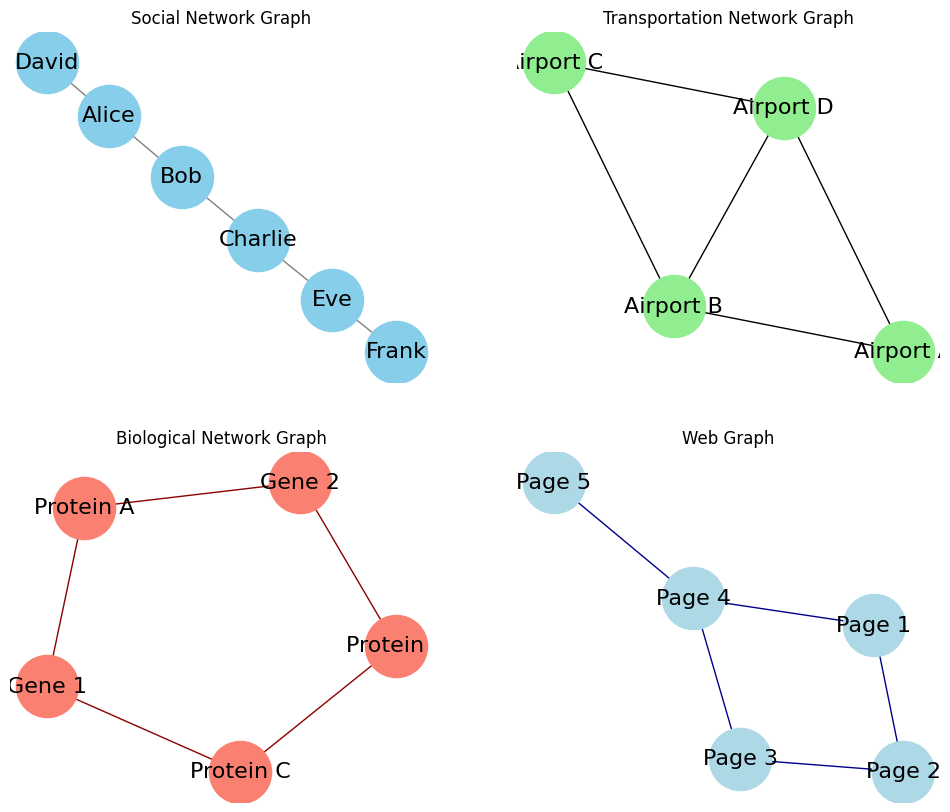

In [58]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a new figure
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Social Network Graph
G_social = nx.Graph()
G_social.add_edges_from([('Alice', 'Bob'), ('Bob', 'Charlie'), ('Alice', 'David'), ('Charlie', 'Eve'), ('Eve', 'Frank')])
nx.draw(G_social, with_labels=True, node_color='skyblue', edge_color='gray', node_size=2000, font_size=16, ax=ax[0, 0])
ax[0, 0].set_title('Social Network Graph')

# Transportation Network Graph
G_transport = nx.Graph()
G_transport.add_edges_from([('Airport A', 'Airport B'), ('Airport B', 'Airport C'), ('Airport C', 'Airport D'), ('Airport A', 'Airport D'), ('Airport B', 'Airport D')])
nx.draw(G_transport, with_labels=True, node_color='lightgreen', edge_color='black', node_size=2000, font_size=16, ax=ax[0, 1])
ax[0, 1].set_title('Transportation Network Graph')

# Biological Network Graph
G_bio = nx.Graph()
G_bio.add_edges_from([('Gene 1', 'Protein A'), ('Protein A', 'Gene 2'), ('Gene 2', 'Protein B'), ('Protein B', 'Protein C'), ('Gene 1', 'Protein C')])
nx.draw(G_bio, with_labels=True, node_color='salmon', edge_color='darkred', node_size=2000, font_size=16, ax=ax[1, 0])
ax[1, 0].set_title('Biological Network Graph')

# Web Graph
G_web = nx.Graph()
G_web.add_edges_from([('Page 1', 'Page 2'), ('Page 2', 'Page 3'), ('Page 3', 'Page 4'), ('Page 1', 'Page 4'), ('Page 4', 'Page 5')])
nx.draw(G_web, with_labels=True, node_color='lightblue', edge_color='darkblue', node_size=2000, font_size=16, ax=ax[1, 1])
ax[1, 1].set_title('Web Graph')

# Save the figure
plt.savefig('./graph_examples.png')
plt.show()
